<a href="https://colab.research.google.com/drive/14GTXbBuO9quCIHIqQXcCoIHWNzQFK-x6?usp=sharing" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import time as time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
mon_features25 = pd.read_csv('/content/drive/MyDrive/mon_features25.csv')
mon_label = pd.read_csv('/content/drive/MyDrive/mon_label.csv')
unmon_features25 = pd.read_csv('/content/drive/MyDrive/unmon_features25.csv')
unmon_label = pd.read_csv('/content/drive/MyDrive/unmon_label.csv')

features25 = pd.concat([mon_features25, unmon_features25], axis=0, ignore_index=True)
labels = pd.concat([mon_label, unmon_label], axis=0, ignore_index=True)

labels[labels == 'unmonitored'] = -1

In [ ]:
print(features25.dtypes)

num_total_packets                       int64
sum_packets                             int64
num_incoming_packets                    int64
frac_incoming_packets                 float64
num_outgoing_packets                    int64
frac_outgoing_packets                 float64
cumulative_packet_size_seq             object
packet_size_ratios                    float64
burst_lengths                           int64
burst_seq                              object
average_incoming_ordering             float64
std_dev_incoming_ordering             float64
average_outgoing_ordering             float64
std_dev_outgoing_ordering             float64
avg_packet_size                       float64
max_packet_size                         int64
avg_inter_arrival_time                float64
var_packet_size                       float64
alternative_packets_per_second_sum    float64
num_packets_per_second                float64
mean_packets_per_second               float64
std_packets_per_second            

In [ ]:
features25 = features25.drop(['cumulative_packet_size_seq', 'burst_seq'], axis=1)
print(features25.head())

   num_total_packets  sum_packets  num_incoming_packets  \
0               1421       727552                  1300   
1                518       265216                   438   
2               1358       695296                  1240   
3               1446       740352                  1324   
4               1406       719872                  1291   

   frac_incoming_packets  num_outgoing_packets  frac_outgoing_packets  \
0               0.914849                   121               0.085151   
1               0.845560                    80               0.154440   
2               0.913108                   118               0.086892   
3               0.915629                   122               0.084371   
4               0.918208                   115               0.081792   

   packet_size_ratios  burst_lengths  average_incoming_ordering  \
0            0.093077            156                 704.106154   
1            0.182648             94                 264.406393   
2    

## Original Code (Before Fine Tuning)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(features25, labels, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

y_train = y_train.values.ravel()
y_val = y_val.values.ravel()
y_test = y_test.values.ravel()

Validation Accuracy: 0.69
Precision: 0.71
Recall: 0.69
F1 Score: 0.69
Confusion Matrix:
 [[278   3   0 ...   3   1   4]
 [  5  17   0 ...   1   0   0]
 [  3   0  16 ...   0   0   0]
 ...
 [  5   0   0 ...  17   0   0]
 [  3   0   0 ...   0  27   0]
 [  6   0   0 ...   0   0  16]]


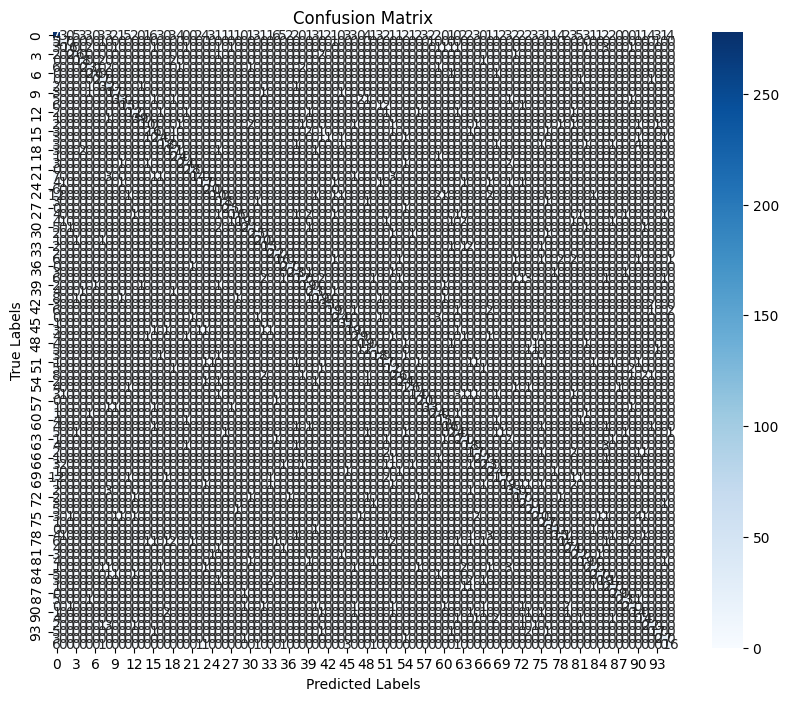


Execution Time: 0.68 minutes


In [ ]:
start_time = time.time()

# Train a RandomForest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate model
y_valid_pred = rf_model.predict(X_val)

# Valid Accuracy
valid_accuracy = accuracy_score(y_val, y_valid_pred)
print(f'Validation Accuracy: {valid_accuracy:.2f}')

# Precision, Recall, F1-Score (Weighted for multi-class)
precision = precision_score(y_val, y_valid_pred, average='weighted')
recall = recall_score(y_val, y_valid_pred, average='weighted')
f1 = f1_score(y_val, y_valid_pred, average='weighted')
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_valid_pred)
print("Confusion Matrix:\n", conf_matrix)

# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


end_time = time.time()
print(f"\nExecution Time: {(end_time - start_time)/60:.2f} minutes")

In [ ]:
# Function to count values in each range
def count_in_ranges(values, ranges):
    counts = {}
    for low, high in ranges:
        if high == 1.0:  # Include the upper boundary for the last range
            count = sum(low <= val <= high for val in values)
        else:
            count = sum(low <= val < high for val in values)
        counts[f"{low:.1f} to {high:.1f}"] = count
    return counts

# Ranges for evaluation
ranges = [(0.9, 1.0), (0.8, 0.9), (0.7, 0.8), (0.6, 0.7), (0.0, 0.6)]

# Generate Classification Report
class_report_dict = classification_report(y_val, y_valid_pred, output_dict=True, target_names=[str(i) for i in range(95)] + ['unmonitored'])

# Extract Precision, Recall, and F1 values for all classes (excluding the 'accuracy' entry)
precision = [class_report_dict[str(i)]['precision'] for i in range(95)] + [class_report_dict['unmonitored']['precision']]
recall = [class_report_dict[str(i)]['recall'] for i in range(95)] + [class_report_dict['unmonitored']['recall']]
f1 = [class_report_dict[str(i)]['f1-score'] for i in range(95)] + [class_report_dict['unmonitored']['f1-score']]

# Count classes in each range for precision, recall, and F1
precision_counts = count_in_ranges(precision, ranges)
recall_counts = count_in_ranges(recall, ranges)
f1_counts = count_in_ranges(f1, ranges)

# Print counts for precision
print("\nPrecision Ranges:")
for r, count in precision_counts.items():
    print(f"  {r}: {count} classes")

# Print counts for recall
print("\nRecall Ranges:")
for r, count in recall_counts.items():
    print(f"  {r}: {count} classes")

# Print counts for F1-Score
print("\nF1-Score Ranges:")
for r, count in f1_counts.items():
    print(f"  {r}: {count} classes")



Precision Ranges:
  0.9 to 1.0: 10 classes
  0.8 to 0.9: 21 classes
  0.7 to 0.8: 29 classes
  0.6 to 0.7: 26 classes
  0.0 to 0.6: 10 classes

Recall Ranges:
  0.9 to 1.0: 13 classes
  0.8 to 0.9: 16 classes
  0.7 to 0.8: 20 classes
  0.6 to 0.7: 25 classes
  0.0 to 0.6: 22 classes

F1-Score Ranges:
  0.9 to 1.0: 9 classes
  0.8 to 0.9: 17 classes
  0.7 to 0.8: 26 classes
  0.6 to 0.7: 26 classes
  0.0 to 0.6: 18 classes


# **Fine-Tuning**

## Drop the features with Zero Importance

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Train a Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Retrieve feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': features25.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importance_df)

# Identify features with zero importance
zero_importance_features = feature_importance_df[feature_importance_df['Importance'] == 0]['Feature'].tolist()
print(f"\nFeatures with zero importance: {zero_importance_features}")

Feature Importances:
                               Feature  Importance
10           average_outgoing_ordering    0.079256
11           std_dev_outgoing_ordering    0.070351
7                        burst_lengths    0.064304
9            std_dev_incoming_ordering    0.057867
4                 num_outgoing_packets    0.057531
8            average_incoming_ordering    0.057468
3                frac_incoming_packets    0.056853
5                frac_outgoing_packets    0.056396
6                   packet_size_ratios    0.055228
2                 num_incoming_packets    0.055088
0                    num_total_packets    0.054269
1                          sum_packets    0.053653
14              avg_inter_arrival_time    0.052933
17              num_packets_per_second    0.050698
19              std_packets_per_second    0.050503
20              med_packets_per_second    0.033881
18             mean_packets_per_second    0.033040
22           num_packets_longest_burst    0.031860
16  altern

In [ ]:
features25 = features25.drop(['avg_packet_size', 'max_packet_size', 'var_packet_size', 'first_packet_direction'], axis=1)

## RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

param_distributions = {
    'n_estimators': [200, 400, 600],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3],
    'max_depth': [None, 10, 20, 30]
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_distributions,
    n_iter=100,  # Number of random combinations to try
    cv=3,
    random_state=42
)

random_search.fit(X_train, y_train)
print(random_search.best_params_)

## GridSearchCv

In [ ]:
param_grid = {
    'n_estimators': [200, 400, 600],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3],
}

start_time = time.time()

grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=param_grid,
                           cv=3,
                           verbose=2,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

end_time = time.time()

print("Best Parameters:", grid_search.best_params_)
print(f"\nExecution Time: {(end_time - start_time)/60:.2f} minutes")

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
# 이미 최적값을 찾은 하이퍼파라미터 고정
fixed_params = {'n_estimators': ---, 'min_samples_split': ---, 'min_samples_leaf': ---}

param_grid = {
    'max_depth': [10, 20, 30, None],         # 트리 최대 깊이
    'max_features': ['sqrt', 'log2']    # 노드에서 사용할 최대 특징 수
    'bootstrap': [True]
}

# RandomForestClassifier에 고정된 값과 탐색할 파라미터를 결합
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, **fixed_params),
    param_grid,
    cv=3,
    n_jobs=-1,  # 병렬 처리로 속도 향상
    verbose=1   # 진행 상황 출력
)

start_time = time.time()

# 학습
grid_search.fit(X_train, y_train)

end_time = time.time()

# 최적의 하이퍼파라미터 출력
print("Best Parameters:", grid_search.best_params_)
print(f"Execution Time: {end_time - start_time:.2f} seconds")

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1}
Execution Time: 1113.25 seconds


In [ ]:
# Random Forest 모델
rf_model = RandomForestClassifier(
    n_estimators=300,          # 최적값: 트리 개수
    min_samples_split=2,       # 최적값: 노드 분할 최소 샘플 수
    min_samples_leaf=1,        # 최적값: 노드 최소 leaf 수
    max_depth=None,            # 최적값: 트리 최대 깊이
    max_features='sqrt',       # 최적값: 노드에서 사용할 최대 특징 수
    random_state=42            # 랜덤 시드
)

start_time = time.time()

rf_model.fit(X_train, y_train)

end_time = time.time()

# 검증 데이터 평가
y_valid_pred = rf_model.predict(X_val)

# Validation Accuracy
valid_accuracy = accuracy_score(y_val, y_valid_pred)
print(f"Validation Accuracy: {valid_accuracy:.2f}")
print(f"Execution Time: {end_time - start_time:.2f} seconds")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Validation Accuracy: 0.70
Execution Time: 51.39 seconds


Precision: 0.71
Recall: 0.70
F1-Score: 0.70

Confusion Matrix:
[[ 15   0   0 ...   0   0   3]
 [  0  15   0 ...   0   0   3]
 [  0   0  27 ...   0   0   1]
 ...
 [  0   0   0 ...  26   0   3]
 [  1   0   0 ...   0  14   8]
 [  2   1   5 ...   0   2 278]]


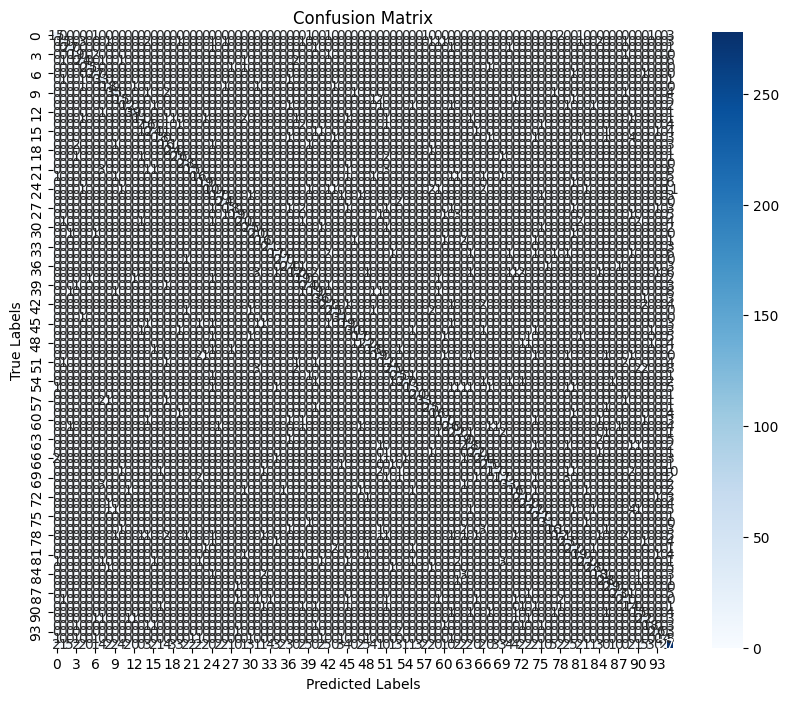

In [ ]:
y_valid_pred = rf_model.predict(X_val)

# Precision, Recall, F1-Score (Weighted)
precision_tuned = precision_score(y_val, y_valid_pred, average='weighted')
recall_tuned = recall_score(y_val, y_valid_pred, average='weighted')
f1_tuned = f1_score(y_val, y_valid_pred, average='weighted')

print(f"Precision: {precision_tuned:.2f}")
print(f"Recall: {recall_tuned:.2f}")
print(f"F1-Score: {f1_tuned:.2f}")

# Confusion Matrix
conf_matrix_tuned = confusion_matrix(y_val, y_valid_pred)
print("\nConfusion Matrix:")
print(conf_matrix_tuned)

# Confusion Matrix 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_tuned, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
import numpy as np

# Convert metrics to NumPy arrays
precision = precision_score(y_val, y_valid_pred, average=None)
recall = recall_score(y_val, y_valid_pred, average=None)
f1 = f1_score(y_val, y_valid_pred, average=None)

# Display all metrics as NumPy arrays
print("\nPrecision for All Classes:")
print(np.array(precision))

print("\nRecall for All Classes:")
print(np.array(recall))

print("\nF1-Score for All Classes:")
print(np.array(f1))

# Confusion Matrix as a NumPy array
print("\nConfusion Matrix:")
print(np.array(conf_matrix_test))


Precision for All Classes:
[0.65217391 0.71428571 0.77142857 0.7037037  0.70588235 0.96153846
 0.79411765 0.67346939 0.72       0.83333333 0.65217391 0.75
 0.92857143 0.61111111 0.59259259 0.77419355 0.85714286 0.53333333
 0.82758621 0.78787879 0.84848485 0.83333333 0.64       0.79166667
 0.41666667 0.85       0.82758621 0.85714286 0.86363636 0.74074074
 0.78125    0.66666667 0.69565217 0.80769231 0.70833333 0.9
 0.70588235 0.66666667 0.57575758 0.70588235 0.67857143 0.85714286
 0.64705882 0.83333333 0.83783784 0.61290323 0.90909091 0.70833333
 0.70967742 0.69230769 0.61290323 0.44444444 0.83333333 0.71428571
 0.93103448 0.65       0.86956522 0.91666667 0.71428571 0.72727273
 0.70833333 0.72222222 0.6875     0.55882353 0.64285714 0.84615385
 0.66666667 0.80645161 0.77272727 0.62962963 0.80487805 0.61538462
 0.72413793 0.78571429 0.64705882 0.84375    0.96875    0.66666667
 0.6        0.65714286 0.61111111 0.7037037  0.84615385 0.875
 0.62068966 0.77777778 0.93548387 0.92       0.7    

In [ ]:
# Ranges for evaluation
ranges = [(0.9, 1.0), (0.8, 0.9), (0.7, 0.8), (0.6, 0.7), (0.0, 0.6)]

# Function to count values in each range
def count_in_ranges(values, ranges):
    counts = {}
    for low, high in ranges:
        count = sum(low <= val < high for val in values)
        counts[f"{low:.1f} to {high:.1f}"] = count
    return counts

# Count classes in each range for precision, recall, and F1
precision_counts = count_in_ranges(precision, ranges)
recall_counts = count_in_ranges(recall, ranges)
f1_counts = count_in_ranges(f1, ranges)

# Print counts for precision
print("\nPrecision Ranges:")
for r, count in precision_counts.items():
    print(f"  {r}: {count} classes")

# Print counts for recall
print("\nRecall Ranges:")
for r, count in recall_counts.items():
    print(f"  {r}: {count} classes")

# Print counts for F1-Score
print("\nF1-Score Ranges:")
for r, count in f1_counts.items():
    print(f"  {r}: {count} classes")


Precision Ranges:
  0.9 to 1.0: 9 classes
  0.8 to 0.9: 23 classes
  0.7 to 0.8: 29 classes
  0.6 to 0.7: 27 classes
  0.0 to 0.6: 8 classes

Recall Ranges:
  0.9 to 1.0: 12 classes
  0.8 to 0.9: 20 classes
  0.7 to 0.8: 21 classes
  0.6 to 0.7: 20 classes
  0.0 to 0.6: 22 classes

F1-Score Ranges:
  0.9 to 1.0: 8 classes
  0.8 to 0.9: 22 classes
  0.7 to 0.8: 23 classes
  0.6 to 0.7: 29 classes
  0.0 to 0.6: 14 classes


## GridSearchCV(2)

In [ ]:
# Random Forest 모델
rf_model = RandomForestClassifier(
    n_estimators=3000,         # 최적값: 트리 개수
    min_samples_split=2,       # 최적값: 노드 분할 최소 샘플 수
    min_samples_leaf=1,        # 최적값: 노드 최소 leaf 수
    max_depth=50  ,            # 최적값: 트리 최대 깊이
    max_features='sqrt',       # 최적값: 노드에서 사용할 최대 특징 수
    random_state=42            # 랜덤 시드
)

start_time = time.time()

rf_model.fit(X_train, y_train)

end_time = time.time()

# 검증 데이터 평가
y_valid_pred = rf_model.predict(X_val)

# Validation Accuracy
valid_accuracy = accuracy_score(y_val, y_valid_pred)
print(f"Validation Accuracy: {valid_accuracy:.2f}")
print(f"Execution Time: {end_time - start_time:.2f} seconds")

In [ ]:
y_valid_pred = rf_model.predict(X_val)

# Precision, Recall, F1-Score (Weighted)
precision_tuned = precision_score(y_val, y_valid_pred, average='weighted')
recall_tuned = recall_score(y_val, y_valid_pred, average='weighted')
f1_tuned = f1_score(y_val, y_valid_pred, average='weighted')

print(f"Precision: {precision_tuned:.2f}")
print(f"Recall: {recall_tuned:.2f}")
print(f"F1-Score: {f1_tuned:.2f}")

# Confusion Matrix
conf_matrix_tuned = confusion_matrix(y_val, y_valid_pred)
print("\nConfusion Matrix:")
print(conf_matrix_tuned)

# Confusion Matrix 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_tuned, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

-------------- 이 아래의 method는 오히려 성능이 나빠짐

## Class Weighting

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

In [ ]:
# Identify underperforming classes based on F1-score
underperforming_classes = [i for i, score in enumerate(f1) if score < 0.7]
print("Underperforming Classes:", underperforming_classes)

Underperforming Classes: [0, 1, 4, 10, 11, 13, 14, 16, 17, 21, 22, 24, 27, 32, 34, 37, 38, 40, 42, 45, 47, 50, 51, 55, 59, 60, 61, 63, 64, 66, 68, 69, 71, 74, 77, 78, 84, 88, 89, 90, 91, 92, 94, 95]


In [ ]:
classes = np.unique(y_train['label'])  # Extract unique classes from the 'label' column
class_weights = compute_class_weight(
    class_weight=None,
    classes=classes,
    y=y_train['label']  # Use the 'label' column for weight calculation
)

# Gradual adjustment: lower weights by a fraction instead of halving
for i, cls in enumerate(classes):
    if cls in underperforming_classes:
        class_weights[i] *= 0.5  # Adjust the weight by a smaller factor

# Convert weights to dictionary
class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}
print("Adjusted Class Weights:", class_weight_dict)

Adjusted Class Weights: {0: 0.7, 1: 0.7, 2: 1.0, 3: 1.0, 4: 0.7, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 0.7, 11: 0.7, 12: 1.0, 13: 0.7, 14: 0.7, 15: 1.0, 16: 0.7, 17: 0.7, 18: 1.0, 19: 1.0, 20: 1.0, 21: 0.7, 22: 0.7, 23: 1.0, 24: 0.7, 25: 1.0, 26: 1.0, 27: 0.7, 28: 1.0, 29: 1.0, 30: 1.0, 31: 1.0, 32: 0.7, 33: 1.0, 34: 0.7, 35: 1.0, 36: 1.0, 37: 0.7, 38: 0.7, 39: 1.0, 40: 0.7, 41: 1.0, 42: 0.7, 43: 1.0, 44: 1.0, 45: 0.7, 46: 1.0, 47: 0.7, 48: 1.0, 49: 1.0, 50: 0.7, 51: 0.7, 52: 1.0, 53: 1.0, 54: 1.0, 55: 0.7, 56: 1.0, 57: 1.0, 58: 1.0, 59: 0.7, 60: 0.7, 61: 0.7, 62: 1.0, 63: 0.7, 64: 0.7, 65: 1.0, 66: 0.7, 67: 1.0, 68: 0.7, 69: 0.7, 70: 1.0, 71: 0.7, 72: 1.0, 73: 1.0, 74: 0.7, 75: 1.0, 76: 1.0, 77: 0.7, 78: 0.7, 79: 1.0, 80: 1.0, 81: 1.0, 82: 1.0, 83: 1.0, 84: 0.7, 85: 1.0, 86: 1.0, 87: 1.0, 88: 0.7, 89: 0.7, 90: 0.7, 91: 0.7, 92: 0.7, 93: 1.0, 94: 0.7, 95: 0.7}


In [ ]:
rf_model = RandomForestClassifier(
    random_state=42,
    class_weight=class_weight_dict  # Pass the custom class weights
)

rf_model.fit(X_train, y_train)

# Evaluate Model Performance on Validation Set
y_valid_pred = rf_model.predict(X_val)

# Validation Metrics
precision = precision_score(y_val, y_valid_pred, average=None)
recall = recall_score(y_val, y_valid_pred, average=None)
f1 = f1_score(y_val, y_valid_pred, average=None)

# Convert to NumPy arrays for full output
print("Precision (All Classes):")
print(np.array(precision))

print("\nRecall (All Classes):")
print(np.array(recall))

print("\nF1-Score (All Classes):")
print(np.array(f1))

# Confusion Matrix
conf_matrix_test = confusion_matrix(y_val, y_valid_pred)
print("\nConfusion Matrix:")
print(np.array(conf_matrix_test))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Precision (All Classes):
[0.61538462 0.93333333 0.75       0.73076923 0.69444444 0.92592593
 0.87096774 0.66       0.85       0.82051282 0.60869565 0.6875
 0.92857143 0.52631579 0.57142857 0.82142857 0.81818182 0.54545455
 0.78571429 0.83333333 0.875      0.72727273 0.53333333 0.76
 0.45454545 0.82608696 0.82758621 0.89473684 0.86956522 0.75
 0.73529412 0.65517241 0.66666667 0.84       0.82352941 0.87096774
 0.64705882 0.56521739 0.63333333 0.67647059 0.60606061 0.85714286
 0.72413793 0.83333333 0.86111111 0.63333333 0.90625    0.66666667
 0.68965517 0.66666667 0.60714286 0.48148148 0.8        0.78787879
 0.89655172 0.72222222 0.86956522 0.94117647 0.72222222 0.7
 0.64       0.67567568 0.63636364 0.61290323 0.67857143 0.75
 0.68571429 0.8        0.68181818 0.62962963 0.89189189 0.57142857
 0.7037037  0.7        0.57894737 0.87096774 0.93939394 0.55172414
 0.65       0.59459459 0.6969697  0.62068966 0.85185185 0.8
 0.60606061 0.81818182 0.93548387 0.84615385 0.73333333 0.5
 0.53846154 0

In [ ]:
precision = precision_score(y_val, y_valid_pred, average='weighted')
recall = recall_score(y_val, y_valid_pred, average='weighted')
f1 = f1_score(y_val, y_valid_pred, average='weighted')

print(f"Precision: {precision_test:.2f}")
print(f"Recall: {recall_test:.2f}")
print(f"F1-Score: {f1_test:.2f}")

Precision: 0.71
Recall: 0.70
F1-Score: 0.69


## XGBoost (Gradient Boosting)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

In [ ]:
# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42, class_weight="balanced")  # 'balanced' handles class imbalance

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Make predictions on validation data
y_val_pred_rf = rf_model.predict(X_val)

# Evaluate the Random Forest model
rf_accuracy = accuracy_score(y_val, y_val_pred_rf)
rf_precision = precision_score(y_val, y_val_pred_rf, average='weighted')
rf_recall = recall_score(y_val, y_val_pred_rf, average='weighted')
rf_f1 = f1_score(y_val, y_val_pred_rf, average='weighted')

print("\nRandom Forest Metrics:")
print(f"Accuracy: {rf_accuracy:.2f}")
print(f"Precision: {rf_precision:.2f}")
print(f"Recall: {rf_recall:.2f}")
print(f"F1-Score: {rf_f1:.2f}")

# Confusion Matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_val, y_val_pred_rf)
print("\nRandom Forest Confusion Matrix:")
print(np.array(conf_matrix_rf))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Random Forest Metrics:
Accuracy: 0.69
Precision: 0.70
Recall: 0.69
F1-Score: 0.69

Random Forest Confusion Matrix:
[[ 15   0   0 ...   0   0   4]
 [  0  16   1 ...   0   0   4]
 [  0   0  28 ...   0   0   0]
 ...
 [  0   0   0 ...  26   0   1]
 [  0   0   0 ...   0  14   9]
 [  2   1   5 ...   0   4 264]]


In [ ]:
# Initialize XGBoost model
xgb_model = XGBClassifier(
    random_state=42,
    objective='multi:softmax',  # For multi-class classification
    num_class=len(np.unique(y_train)),  # Number of classes
    scale_pos_weight=1  # Adjust this for class imbalance
)

# Train the XGBoost model
xgb_model.fit(X_train, y_train)

# Make predictions on validation data
y_val_pred_xgb = xgb_model.predict(X_val)

# Evaluate the XGBoost model
xgb_accuracy = accuracy_score(y_val, y_val_pred_xgb)
xgb_precision = precision_score(y_val, y_val_pred_xgb, average='weighted')
xgb_recall = recall_score(y_val, y_val_pred_xgb, average='weighted')
xgb_f1 = f1_score(y_val, y_val_pred_xgb, average='weighted')

print("\nXGBoost Metrics:")
print(f"Accuracy: {xgb_accuracy:.2f}")
print(f"Precision: {xgb_precision:.2f}")
print(f"Recall: {xgb_recall:.2f}")
print(f"F1-Score: {xgb_f1:.2f}")

# Confusion Matrix for XGBoost
conf_matrix_xgb = confusion_matrix(y_val, y_val_pred_xgb)
print("\nXGBoost Confusion Matrix:")
print(np.array(conf_matrix_xgb))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:18:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Metrics:
Accuracy: 0.66
Precision: 0.70
Recall: 0.66
F1-Score: 0.67

XGBoost Confusion Matrix:
[[ 11   0   0 ...   0   1   8]
 [  0  14   1 ...   0   0   5]
 [  0   0  25 ...   0   0   4]
 ...
 [  0   0   0 ...  25   0   4]
 [  0   0   0 ...   0  17   7]
 [  0   1   2 ...   0   4 331]]


In [ ]:
# Display a side-by-side comparison
print("\nModel Comparison:")
print("Metric\t\tRandom Forest\tXGBoost")
print(f"Accuracy\t{rf_accuracy:.2f}\t\t{xgb_accuracy:.2f}")
print(f"Precision\t{rf_precision:.2f}\t\t{xgb_precision:.2f}")
print(f"Recall\t\t{rf_recall:.2f}\t\t{xgb_recall:.2f}")
print(f"F1-Score\t{rf_f1:.2f}\t\t{xgb_f1:.2f}")



Model Comparison:
Metric		Random Forest	XGBoost
Accuracy	0.69		0.66
Precision	0.70		0.70
Recall		0.69		0.66
F1-Score	0.69		0.67


## Test Set Accuracy

In [ ]:
# 테스트 데이터 평가
y_test_pred = rf_model.predict(X_test)

# Test Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTest Accuracy: {test_accuracy:.2f}")


Test Accuracy: 0.71
